# Mortality Rate Estimation 

The data found for previous disease outbreaks will come into use to tune the model for regression. We will mostly focus on other Coronaviruses outbreaks (i.e., SARS or MERS) to construct the estimates.

In [7]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

plt.rcParams['figure.figsize']=[40,20]
plt.rcParams['font.size']=22
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 24

## Utility Functions

In [2]:
def calculate_survival_rate(ts, dead_col='Dead', infected_col='Infected'):
    return 1 - ts.iloc[-1][dead_col] / ts.iloc[-1][infected_col]

def calculate_d_hat(X, alpha, T, K):
    d_hat = np.zeros(T)

    for t in range(T):
        for k in range(min(t+1, K)):
            d_hat[t] += alpha * ((1 - alpha) ** (k + 1)) * X[t - k]

    return d_hat

def greedy_d_hat(X, alpha, k0, alpha_k0, T, K):
    d_hat = np.zeros(T)
    
    for t in range(T):
        for k in range(min(t+1, k0)):
            d_hat[t] += alpha * ((1 - alpha) ** (k + 1)) * X[t - k]
            
        if t >= k0:
            d_hat[t] += alpha_k0 * ((1 - alpha) ** (k0 + 1)) * X[t - k0]
            
            for k in range(k0, min(t + 1, K)):
                d_hat[t] += alpha * (1 - alpha_k0) * ((1 - alpha) ** (k + 2)) * X[t - k]

    return d_hat

def estimate_death_curve(X, d, S=None, K=None, verbose=True, alpha_samples=1000, return_optimal_values=False):
    T = X.size
    
    minimum_alpha = None
    minimum_K = None
    minimum_distance = None
    minimum_d_hat = None
    
    change_K_flag = (K is None and S is not None)
    
    alpha_space = np.linspace(0.0001, 0.1, alpha_samples)
    
    for alpha in alpha_space:
        if change_K_flag:
            K = int(np.ceil(np.log(S) / np.log(1 - alpha)))
        
        d_hat = calculate_d_hat(X, alpha, T, K)
        
        distance = np.linalg.norm(d - d_hat)

        if minimum_distance is None or distance < minimum_distance:
            minimum_distance = distance
            
            minimum_d_hat = d_hat
            minimum_K = K
            minimum_alpha = alpha
            
    if verbose:
        print(f"Minimum distance={minimum_distance}\nOptimal K={minimum_K}\nOptimal alpha={minimum_alpha}")
            
    if return_optimal_values:
        return (pd.DataFrame.from_dict({"d": d, "d_hat": minimum_d_hat}), minimum_K, minimum_alpha)
    
    return pd.DataFrame.from_dict({"d": d, "d_hat": minimum_d_hat})

def mortality_interval(mortality_rate, interval_size):
    return mortality_rate * (1 - interval_size), mortality_rate * (1 + interval_size)

censor = lambda x, n: x.iloc[:n]

def plot_censored_mortality_rate_estimation_evolution(ts, censor_start, censor_end, survival_rate=None, K=None):
    results = []
    
    for i in range(censor_start, censor_end):
        censored_ts = censor(ts, i)

        censored_ts['Estimate Dead'] = estimate_death_curve(
            censored_ts['Infected'].values,
            censored_ts['Dead'].values,
            S=survival_rate,
            K=K,
            verbose=False
        ).set_index(censored_ts.index)['d_hat']
        
        estimated_mortality_rate = 1 - calculate_survival_rate(censored_ts.cumsum(), dead_col='Estimate Dead')

        results.append(estimated_mortality_rate)

    fig, ax = plt.subplots()
    plt.plot(range(censor_start, censor_end), results)
    
    if survival_rate is not None:
        lower_mortality, upper_mortality = mortality_interval(1 - survival_rate, 0.2)
        plt.hlines([lower_mortality, upper_mortality], censor_start, censor_end, colors='red')

        lower_mortality, upper_mortality = mortality_interval(1 - survival_rate, 0.1)
        plt.hlines([lower_mortality, upper_mortality], censor_start, censor_end, colors='orange')

        lower_mortality, upper_mortality = mortality_interval(1 - survival_rate, 0.05)
        plt.hlines([lower_mortality, upper_mortality], censor_start, censor_end, colors='green')
    
    plt.show()
    
def fit_smooth_diff_curve(ts, sampling_rate='W'):
    S = calculate_survival_rate(ts)
    
    smooth_diff_ts = ts.diff().resample(sampling_rate).sum()
    
    estimate_death_curve(smooth_diff_ts['Infected'].values, smooth_diff_ts['Dead'].values, S).plot()
    plt.show()
    
    return smooth_diff_ts

## SARS

The dataset on the 2003 SARS outbreak was found on Kaggle and based on WHO reports during the crisis.

In [39]:
sars_ts = pd.read_csv('data/time_series/cumulative/SARS.csv', header=0, index_col=0, parse_dates=[0])

## Survivability Rate

First, we must calculate the survival rate $S_{SARS}$ from our data. A value of $90.36\%$ is in line with the rate in [this paper](doi:10.1016/j.socscimed.2006.08.004) (as per Wikipedia, as I have no access to the paper). 

In [40]:
S_sars = calculate_survival_rate(sars_ts)
S_sars

0.9036387341472087

## Estimate Mortality Curve

Given that the mortality data available is only aggregate level, we must consider the sum of deltas to have a smoother objective function to estimate.

In [44]:
smooth_sars_ts = sars_ts.diff().resample('3D').sum()

In [45]:
death_curve, K, alpha = estimate_death_curve(
    smooth_sars_ts['Infected'].values,
    smooth_sars_ts['Dead'].values,
    S_sars,
    return_optimal_values=True
)

Minimum distance=55.298601324122615
Optimal K=11
Optimal alpha=0.0097


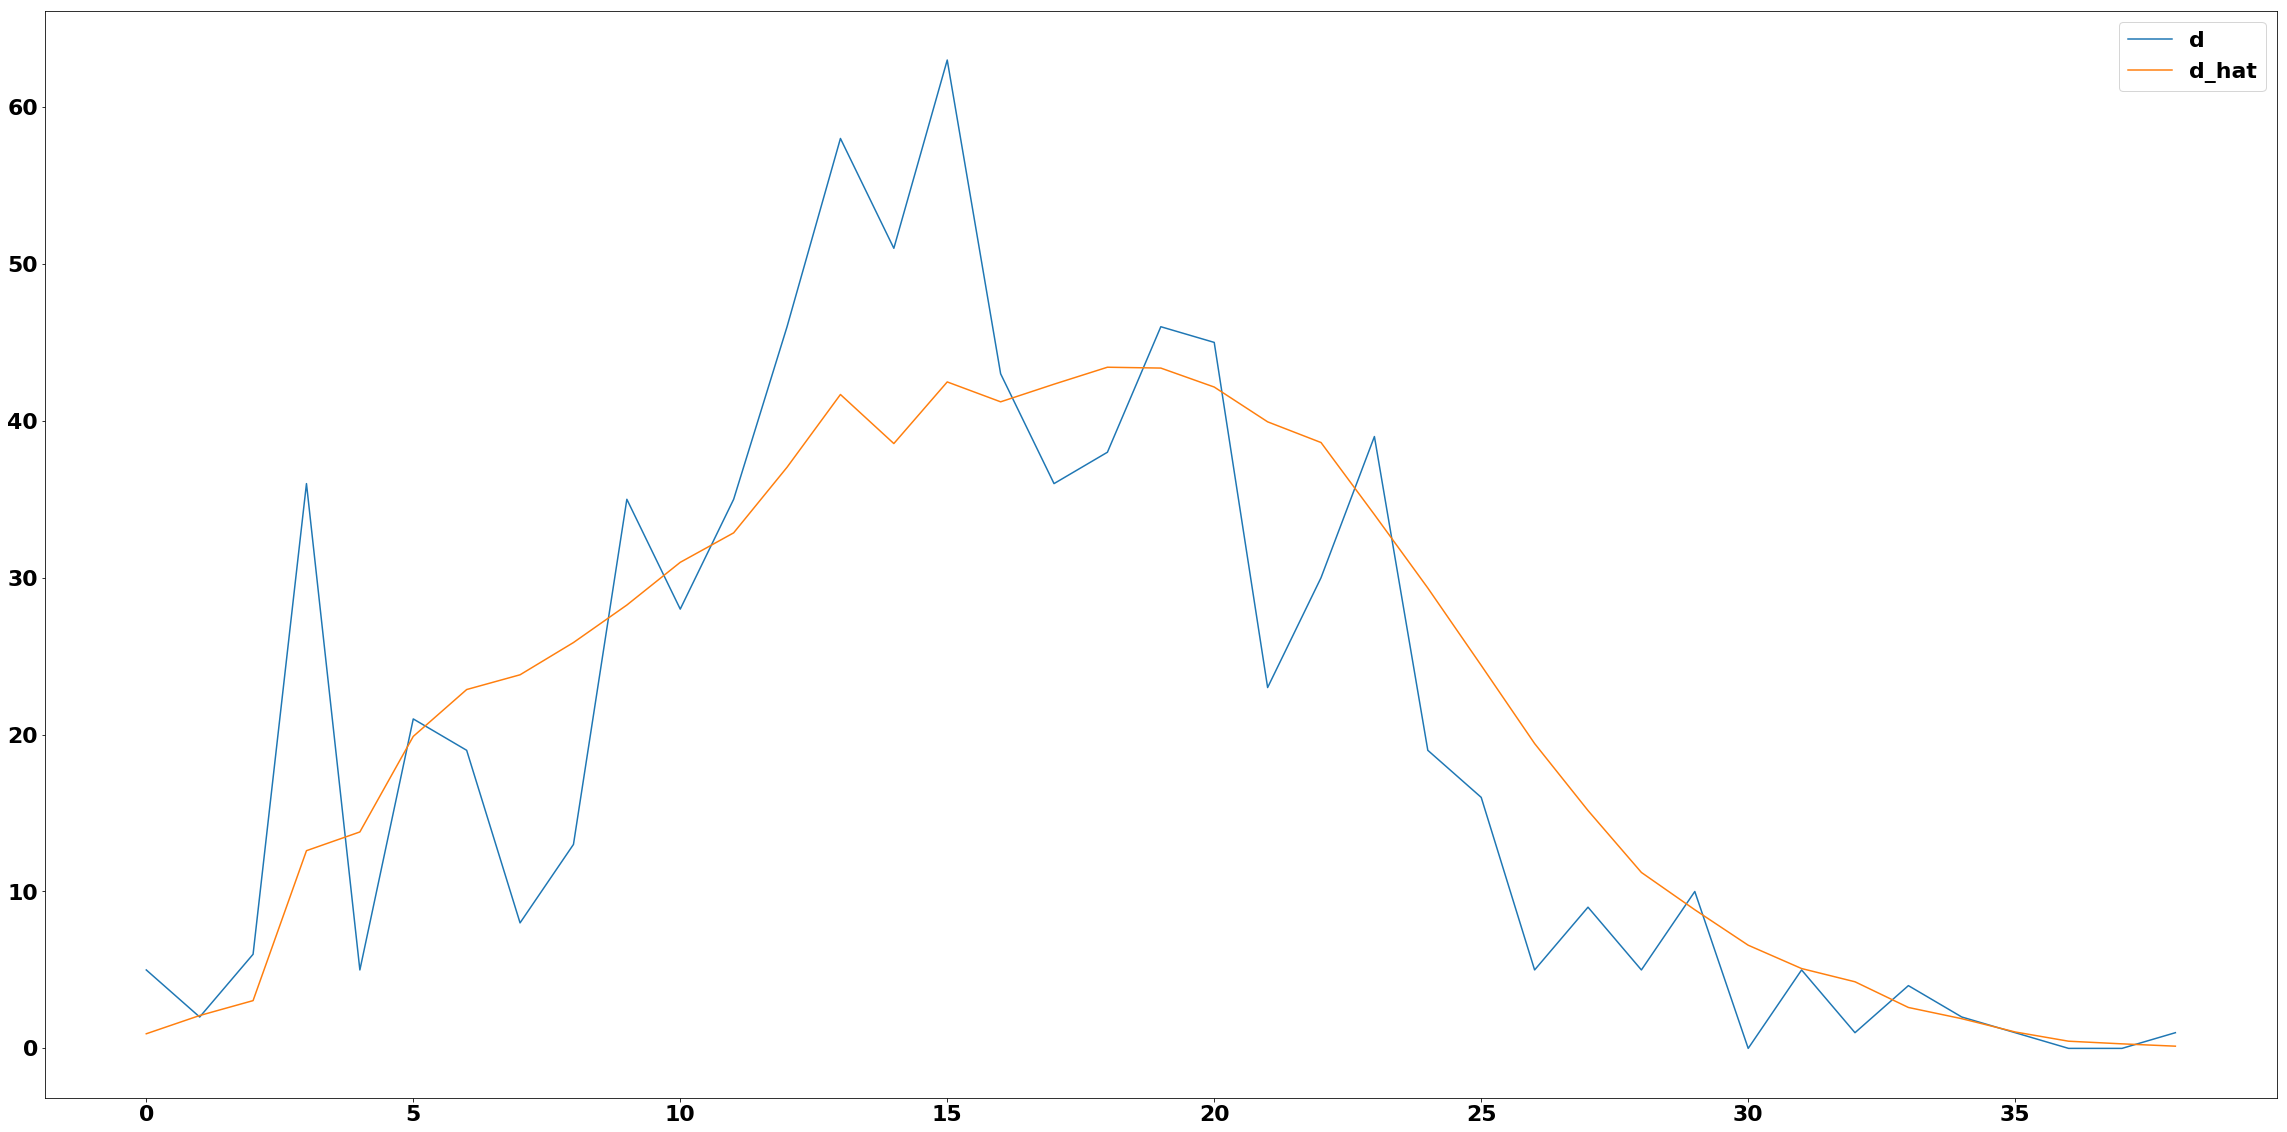

In [46]:
death_curve.plot()

In [6]:
# n_iters = 100

# mean = 0.5
# stddev = 0.5

# X = smooth_sars_ts['Infected'].values
# T = X.shape[0]
# d = death_curve['d']

# optimal_alphas = np.zeros(K)

# for k0 in range(K):
#     minimum_distance = None
#     for _ in range(n_iters):
#         alpha_k0 = 0.01 * np.random.normal() + alpha
            
#         d_hat = greedy_d_hat(X, alpha, k0, alpha_k0, T, K)

#         distance = np.linalg.norm(d - d_hat)
        
#         if minimum_distance is None 
    

# for _ in range(n_iters):
#     noise_vector = stddev * np.random.randn(death_curve.shape[0]) + mean
    
#     d = death_curve['d']
#     d_hat = death_curve['d_hat'] + noise_vector
    
#     distance = np.linalg.norm(d - d_hat)
    
#     print(distance)

## Censored Data

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


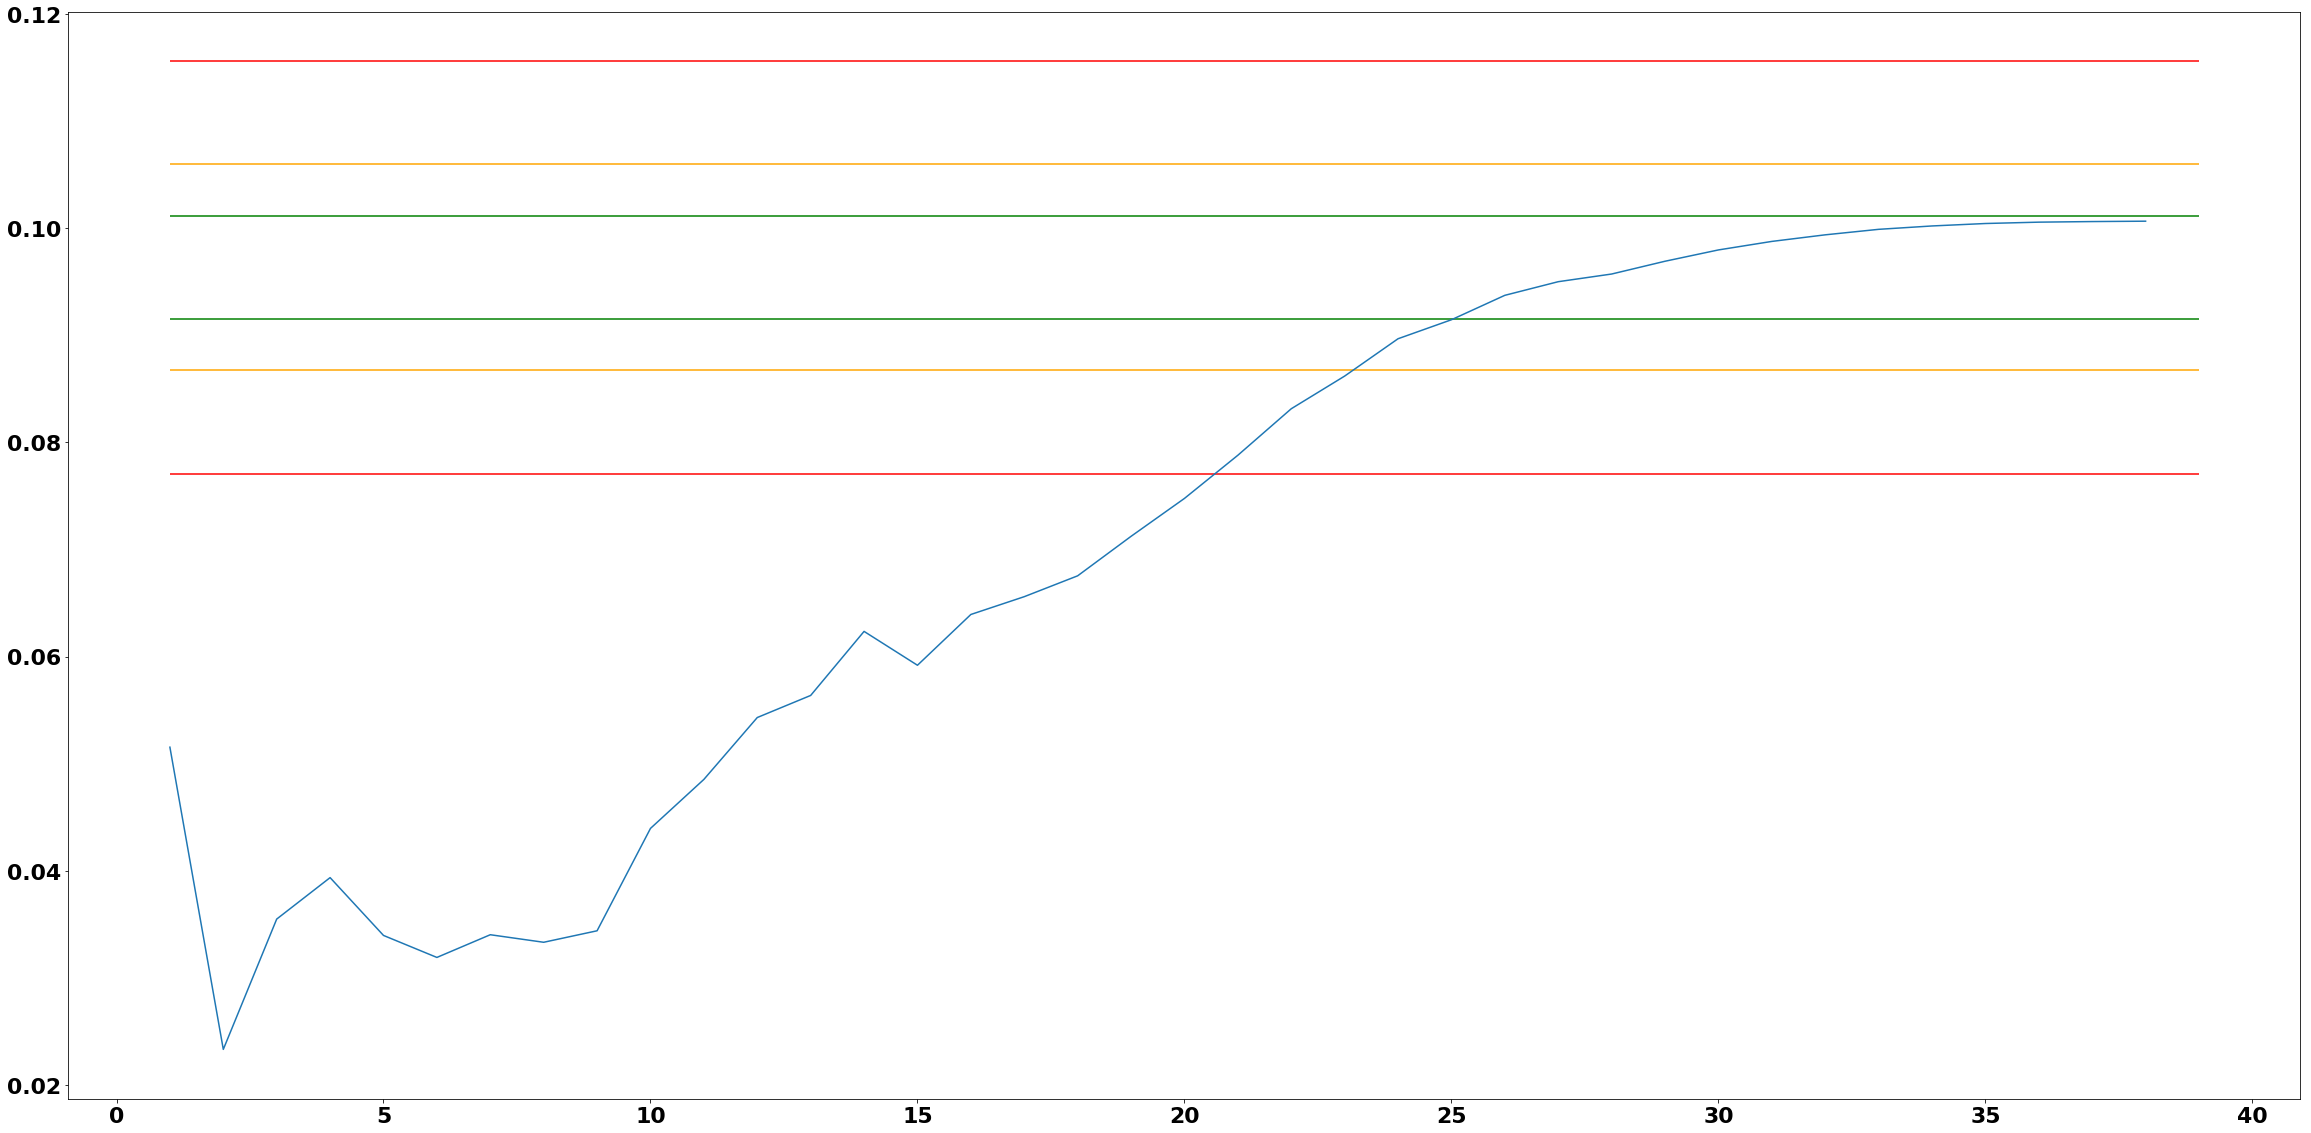

In [81]:
plot_censored_mortality_rate_estimation_evolution(smooth_sars_ts, 1, smooth_sars_ts.shape[0], S_sars)

## MERS

#### First MERS

In [54]:
first_mers_ts = pd.read_csv('data/time_series/cumulative/MERS_first.csv', header=0, index_col=0, parse_dates=[0])

In [55]:
S_first_mers = calculate_survival_rate(first_mers_ts)
S_first_mers

0.7142857142857143

In [56]:
first_smooth_mers_ts = first_mers_ts.diff().resample('7D').sum()

Minimum distance=9.71926556930374
Optimal K=4
Optimal alpha=0.0835


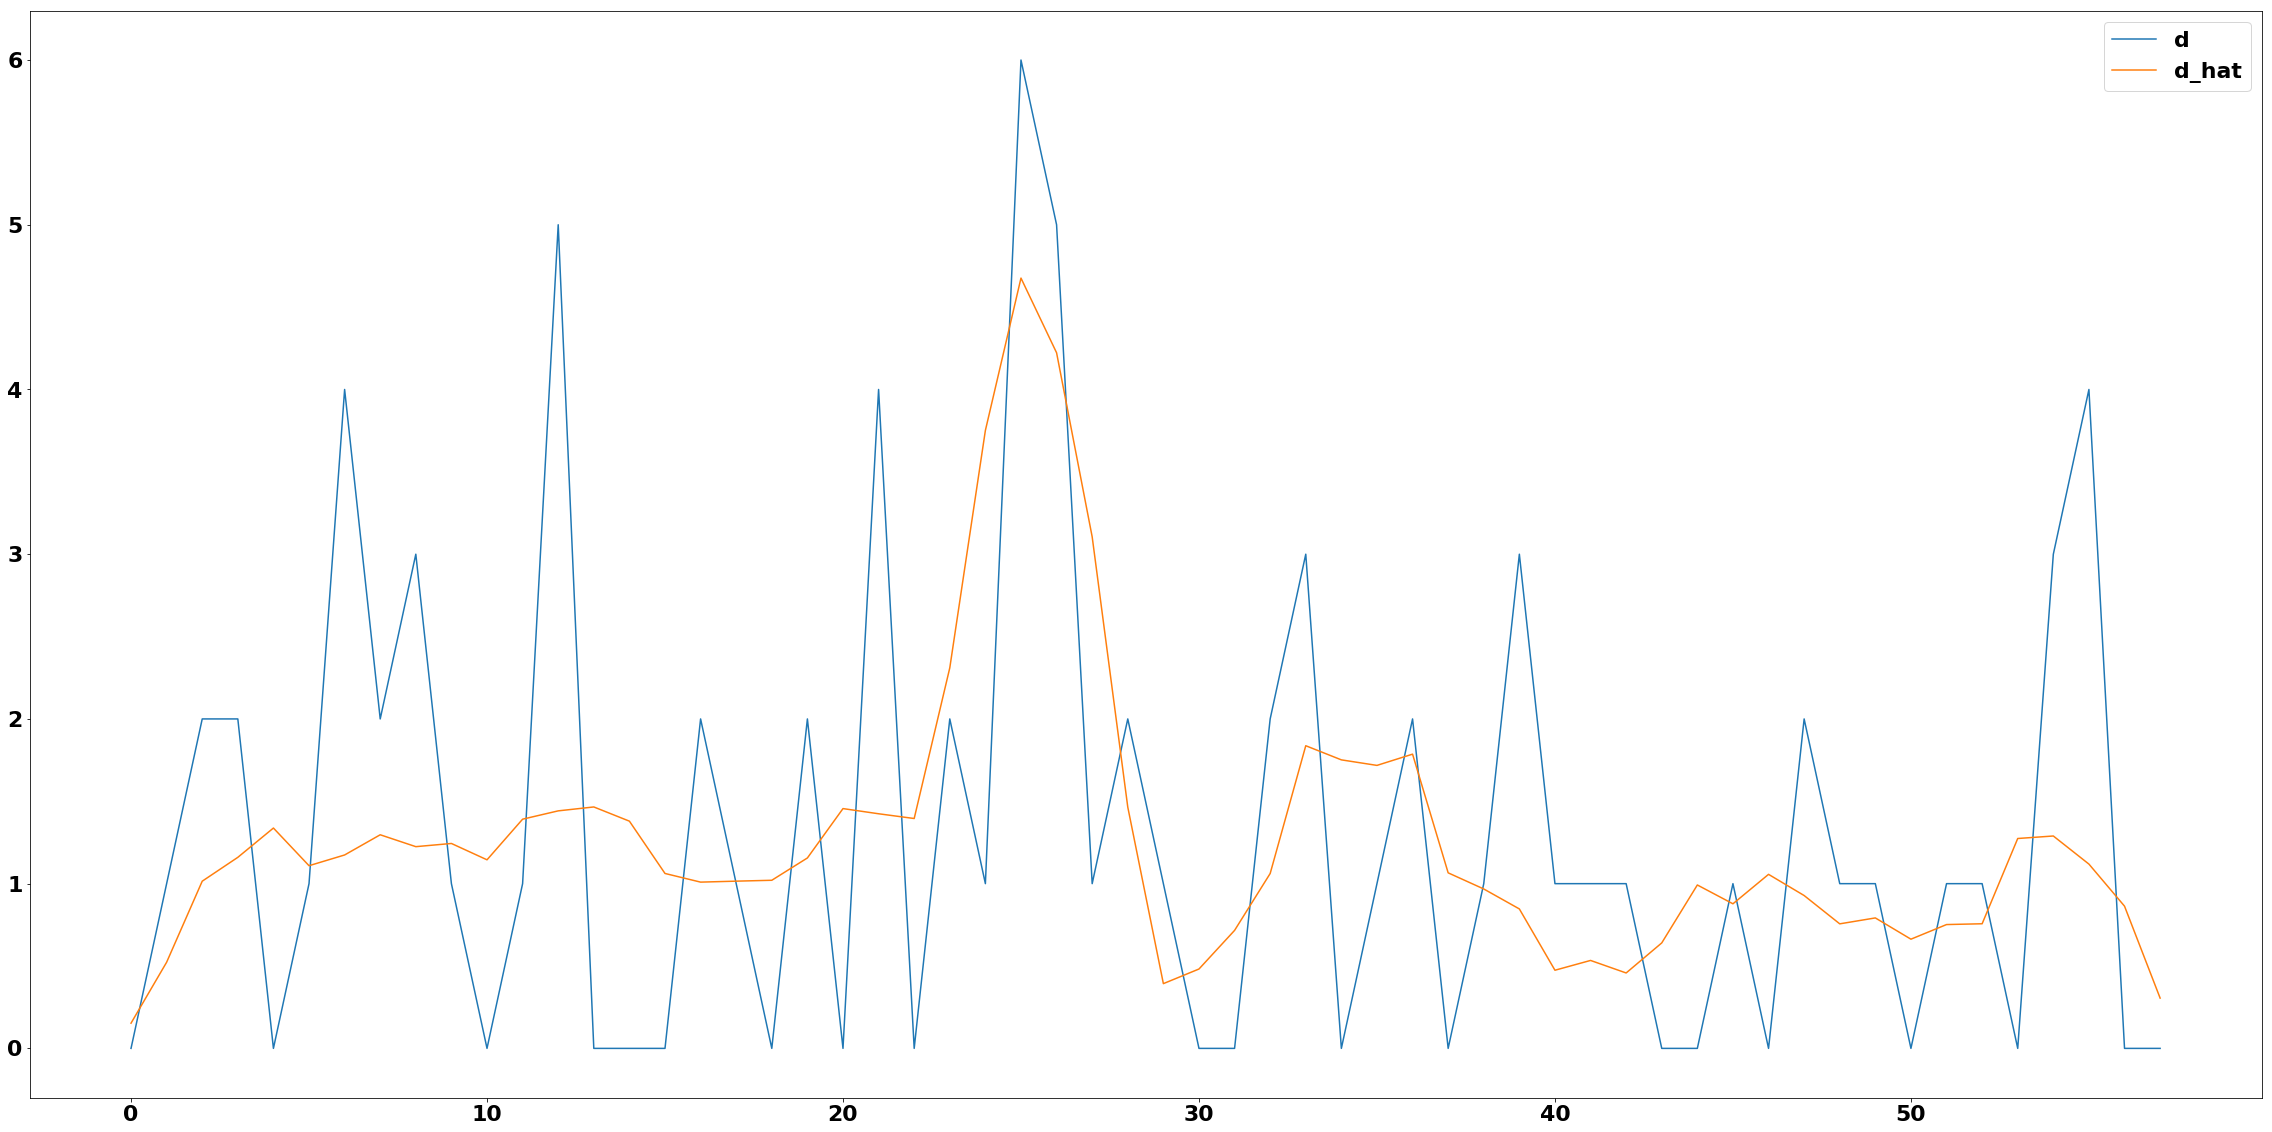

In [57]:
first_death_curve = estimate_death_curve(
    first_smooth_mers_ts['Infected'].values,
    first_smooth_mers_ts['Dead'].values,
    S_first_mers
)
first_death_curve.plot()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


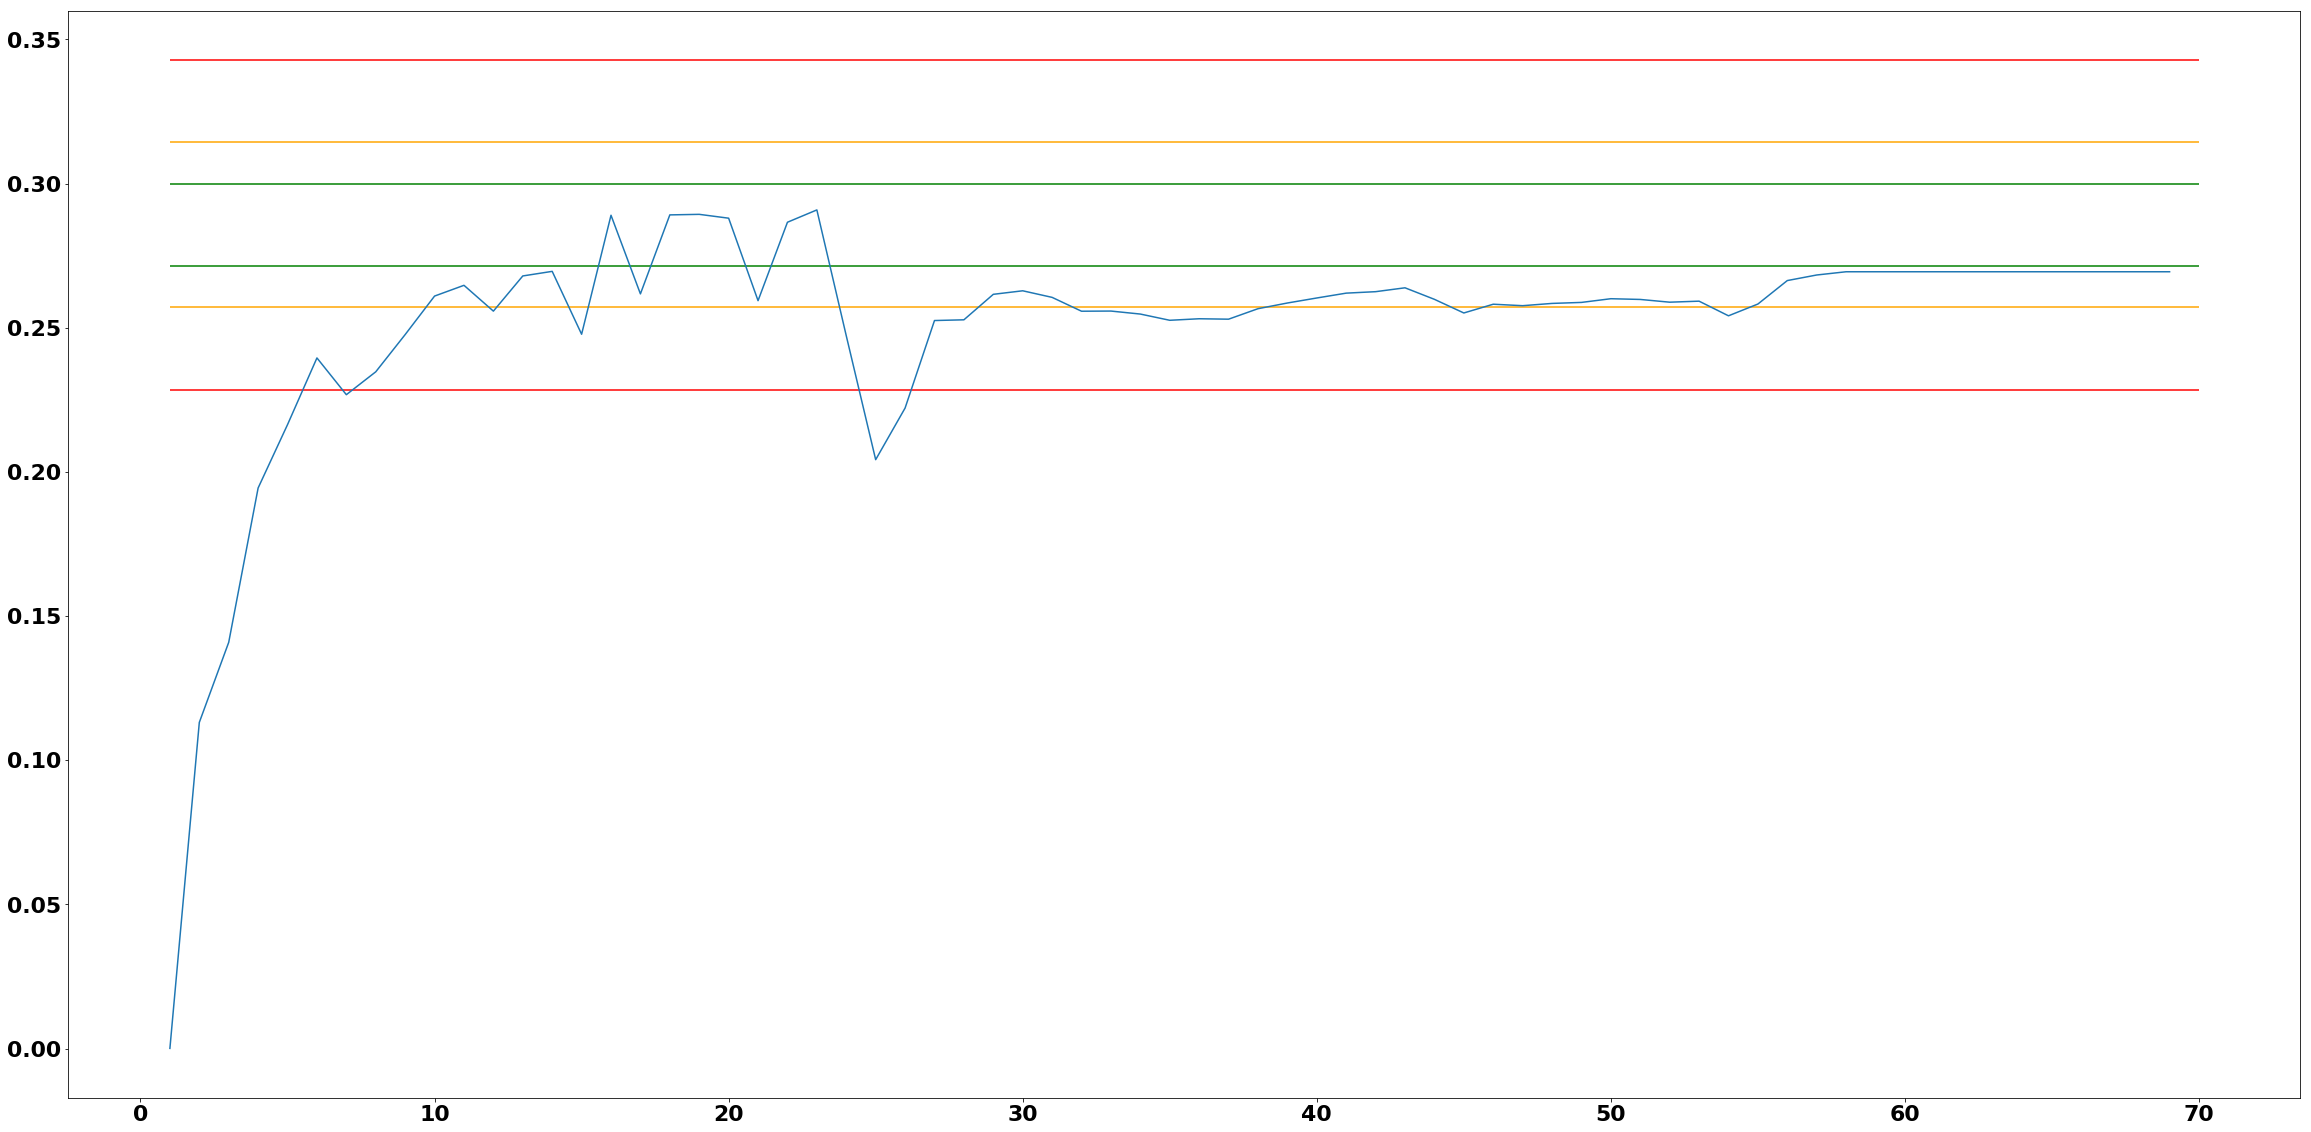

In [25]:
plot_censored_mortality_rate_estimation_evolution(first_smooth_mers_ts, 1, 70, S_first_mers)

#### Second MERS

In [58]:
second_mers_ts = pd.read_csv('data/time_series/cumulative/MERS_second.csv', header=0, index_col=0, parse_dates=[0])

In [59]:
S_second_mers = calculate_survival_rate(second_mers_ts)
S_second_mers

0.7589285714285714

In [29]:
second_smooth_mers_ts = second_mers_ts.diff().resample('7D').sum()

Minimum distance=6.926030820079116
Optimal K=3
Optimal alpha=0.09740000000000001


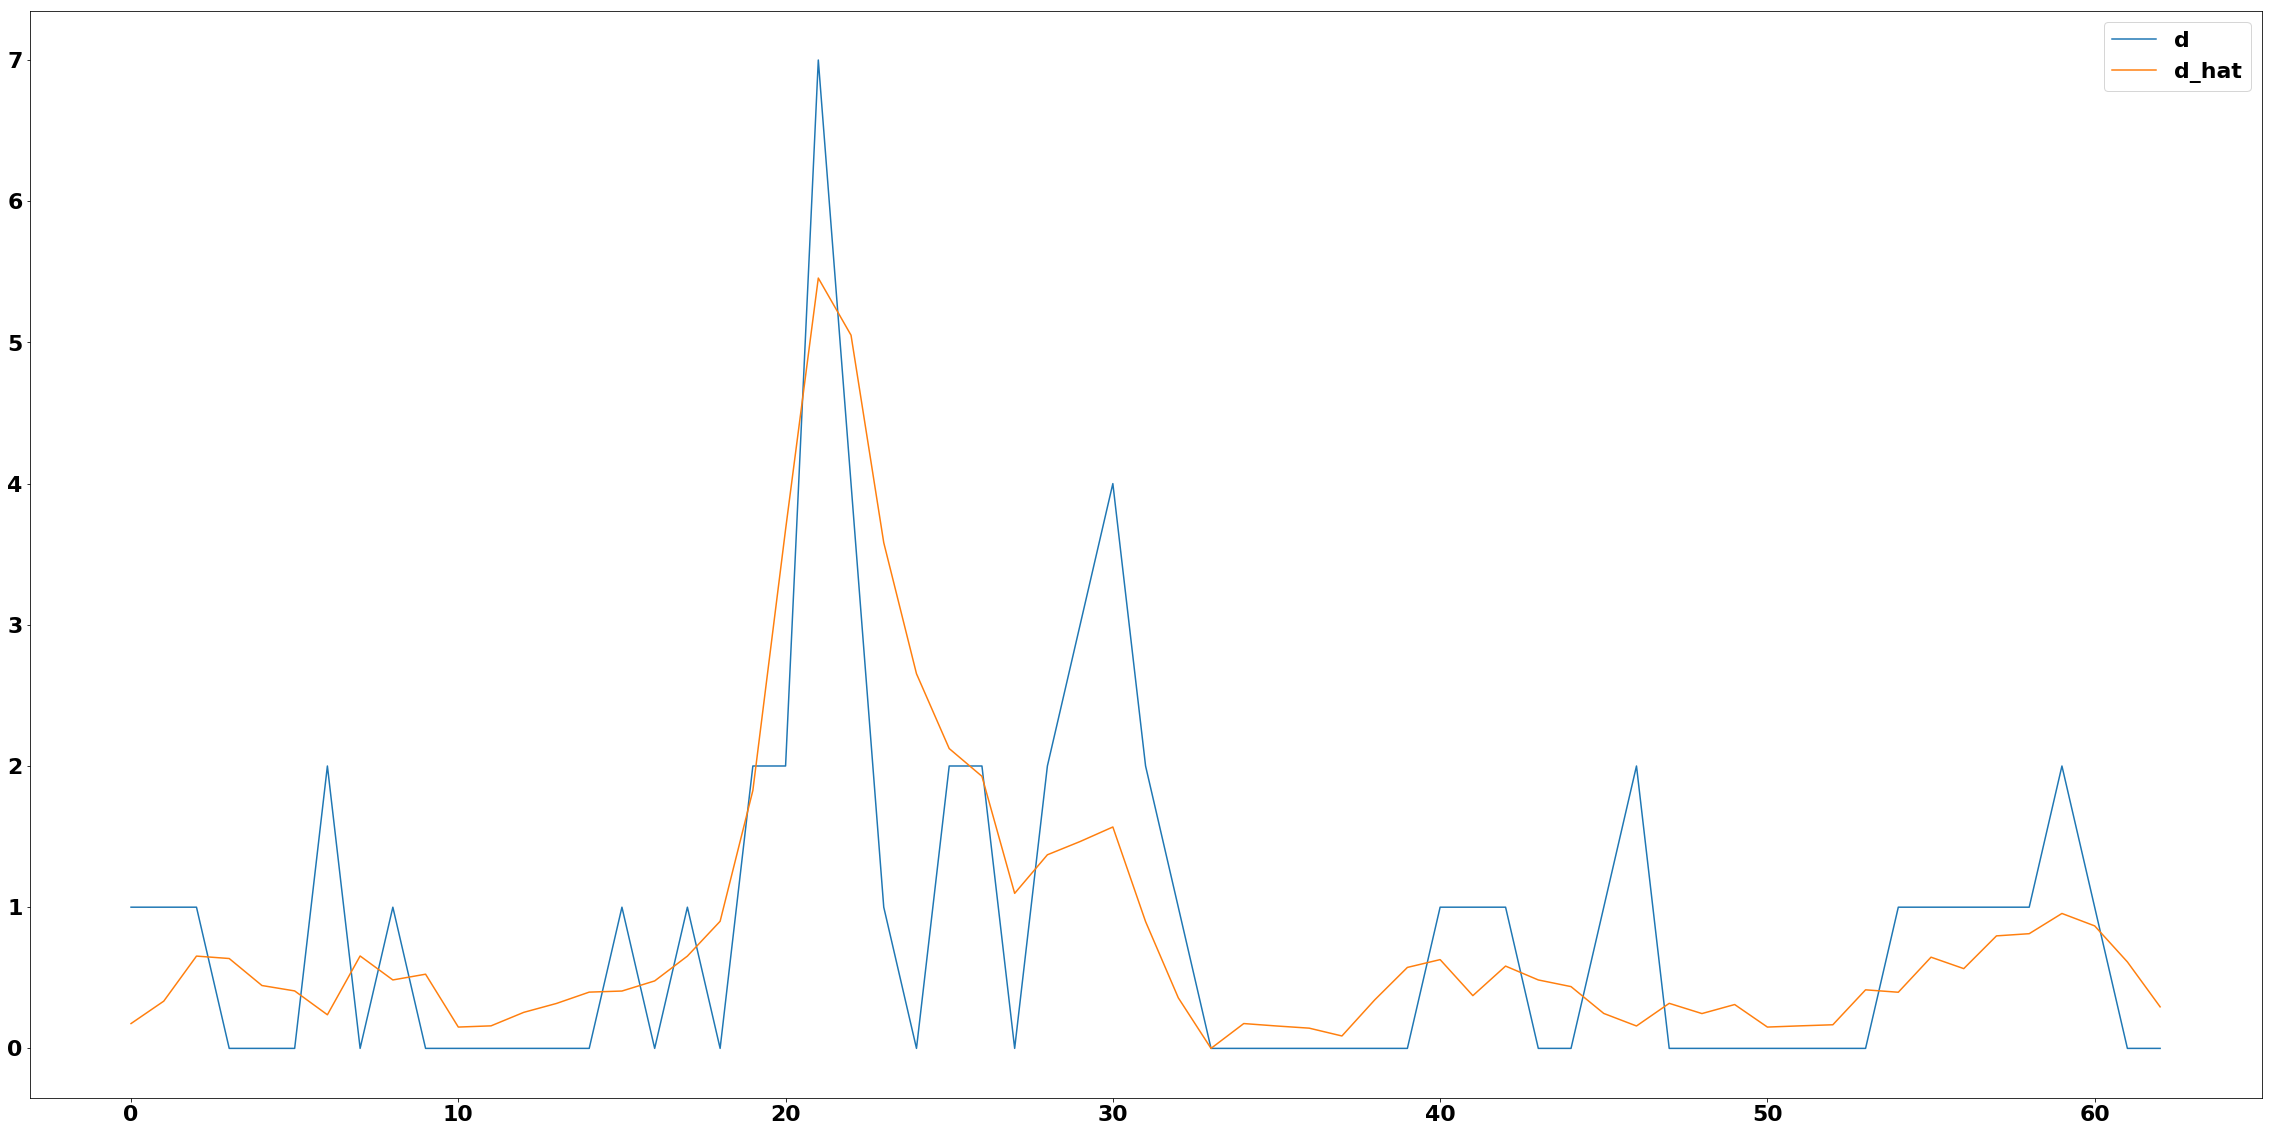

In [30]:
second_death_curve = estimate_death_curve(
    second_smooth_mers_ts['Infected'].values,
    second_smooth_mers_ts['Dead'].values,
    S_mers
)

second_death_curve.plot()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


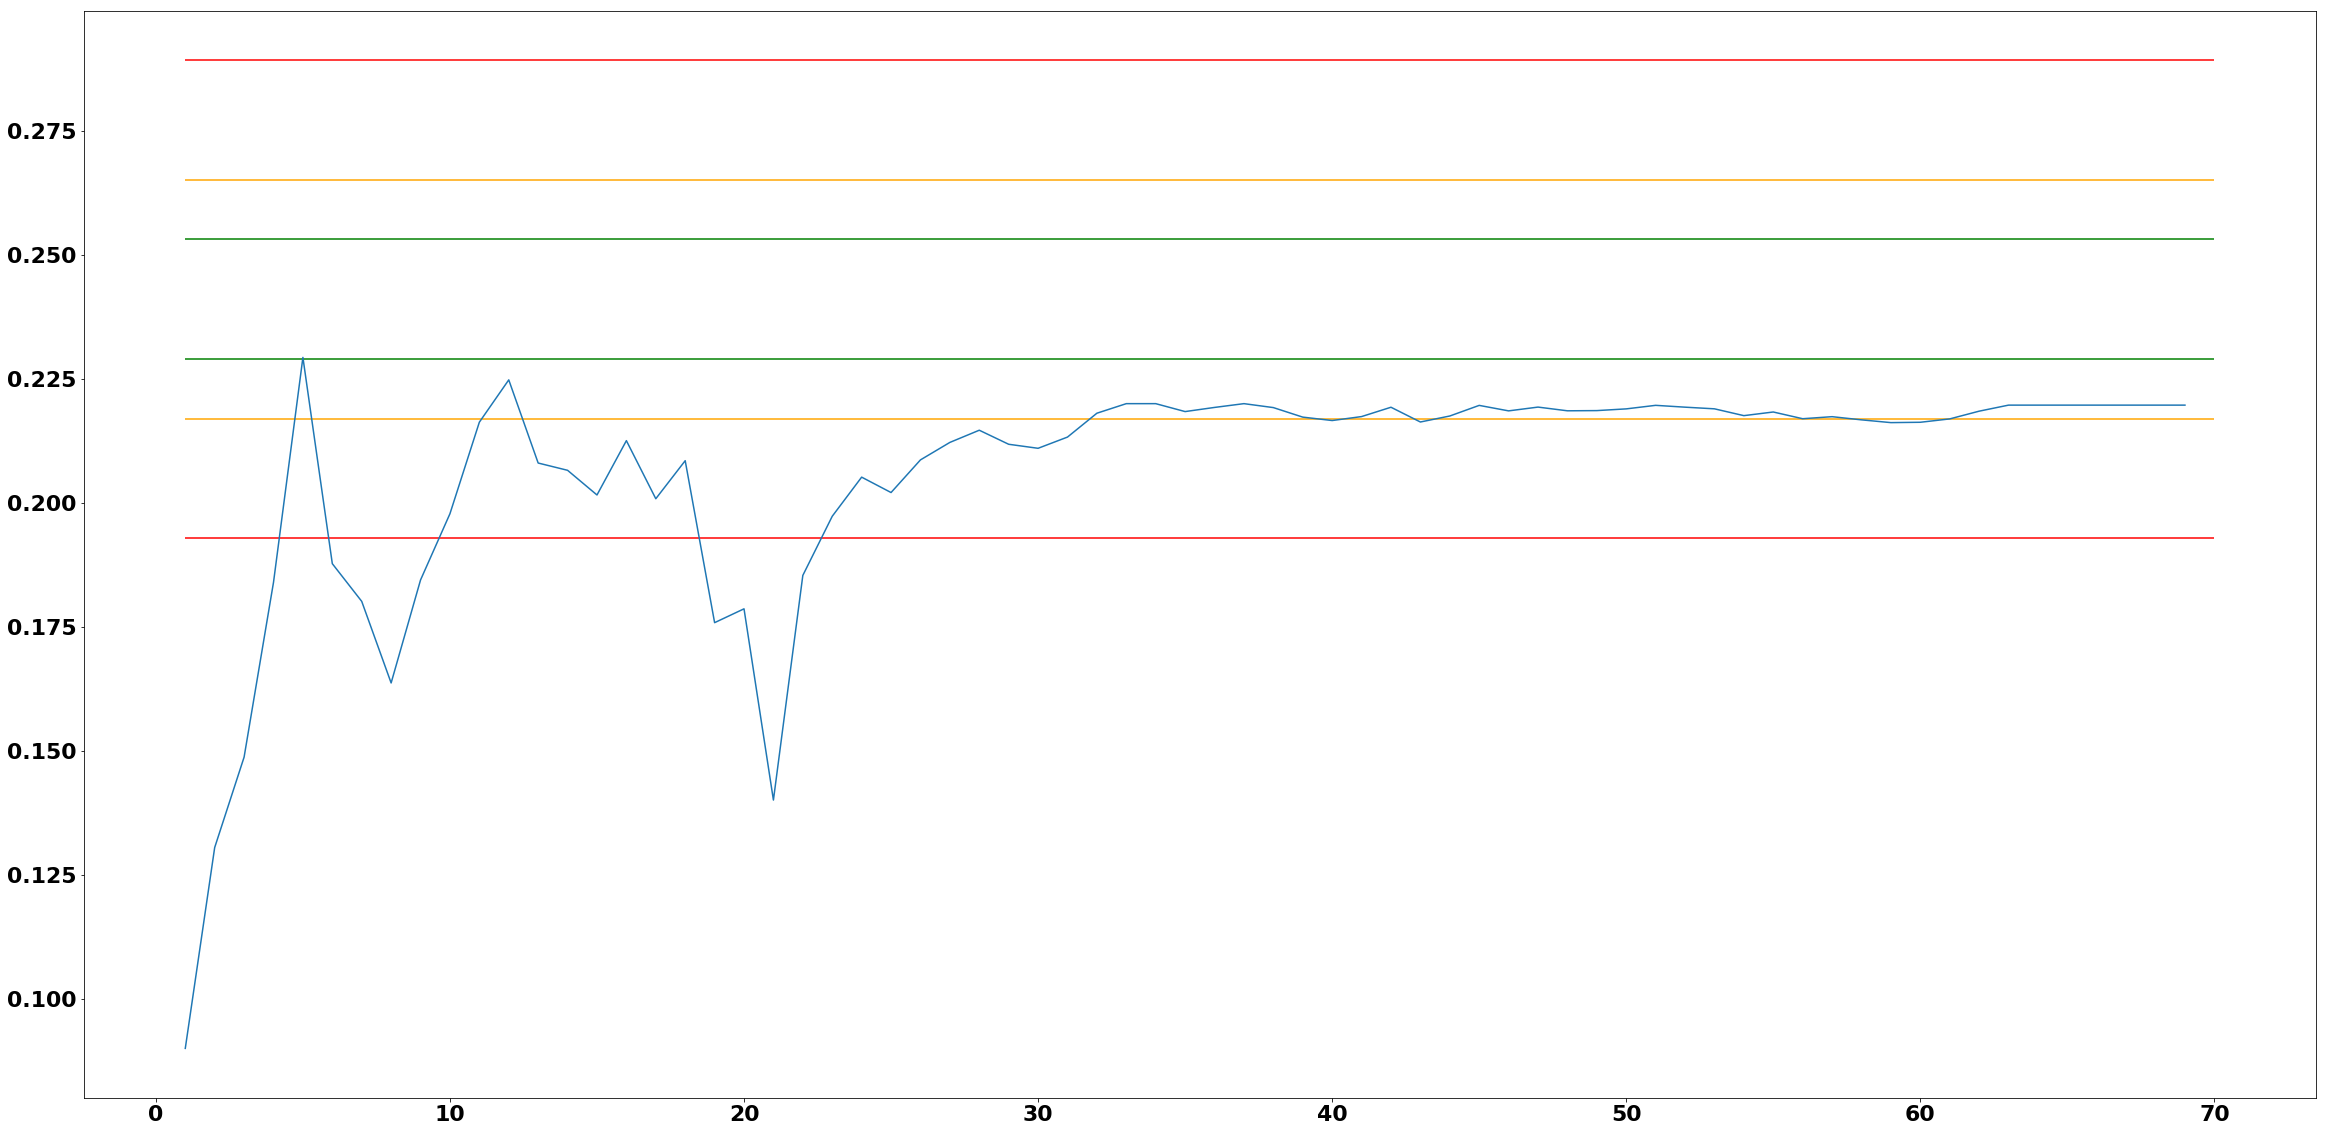

In [31]:
plot_censored_mortality_rate_estimation_evolution(second_smooth_mers_ts, 1, 70, S_second_mers)

### Patient level data

In [108]:
mers_patients_df = pd.read_csv('data/MERS/MERS_middle_east_patients.csv', parse_dates=[1, 3, 4], index_col=0)

In [105]:
survived_index = mers_patients_df[mers_patients_df['Date of outcome'].isna()].index

In [116]:
mers_patients_df.loc[survived_index, 'Date of outcome'] = pd.to_datetime("2020-01-01")

## Ebola

Minimum distance=161.47972039396512
Optimal K=10
Optimal alpha=0.1


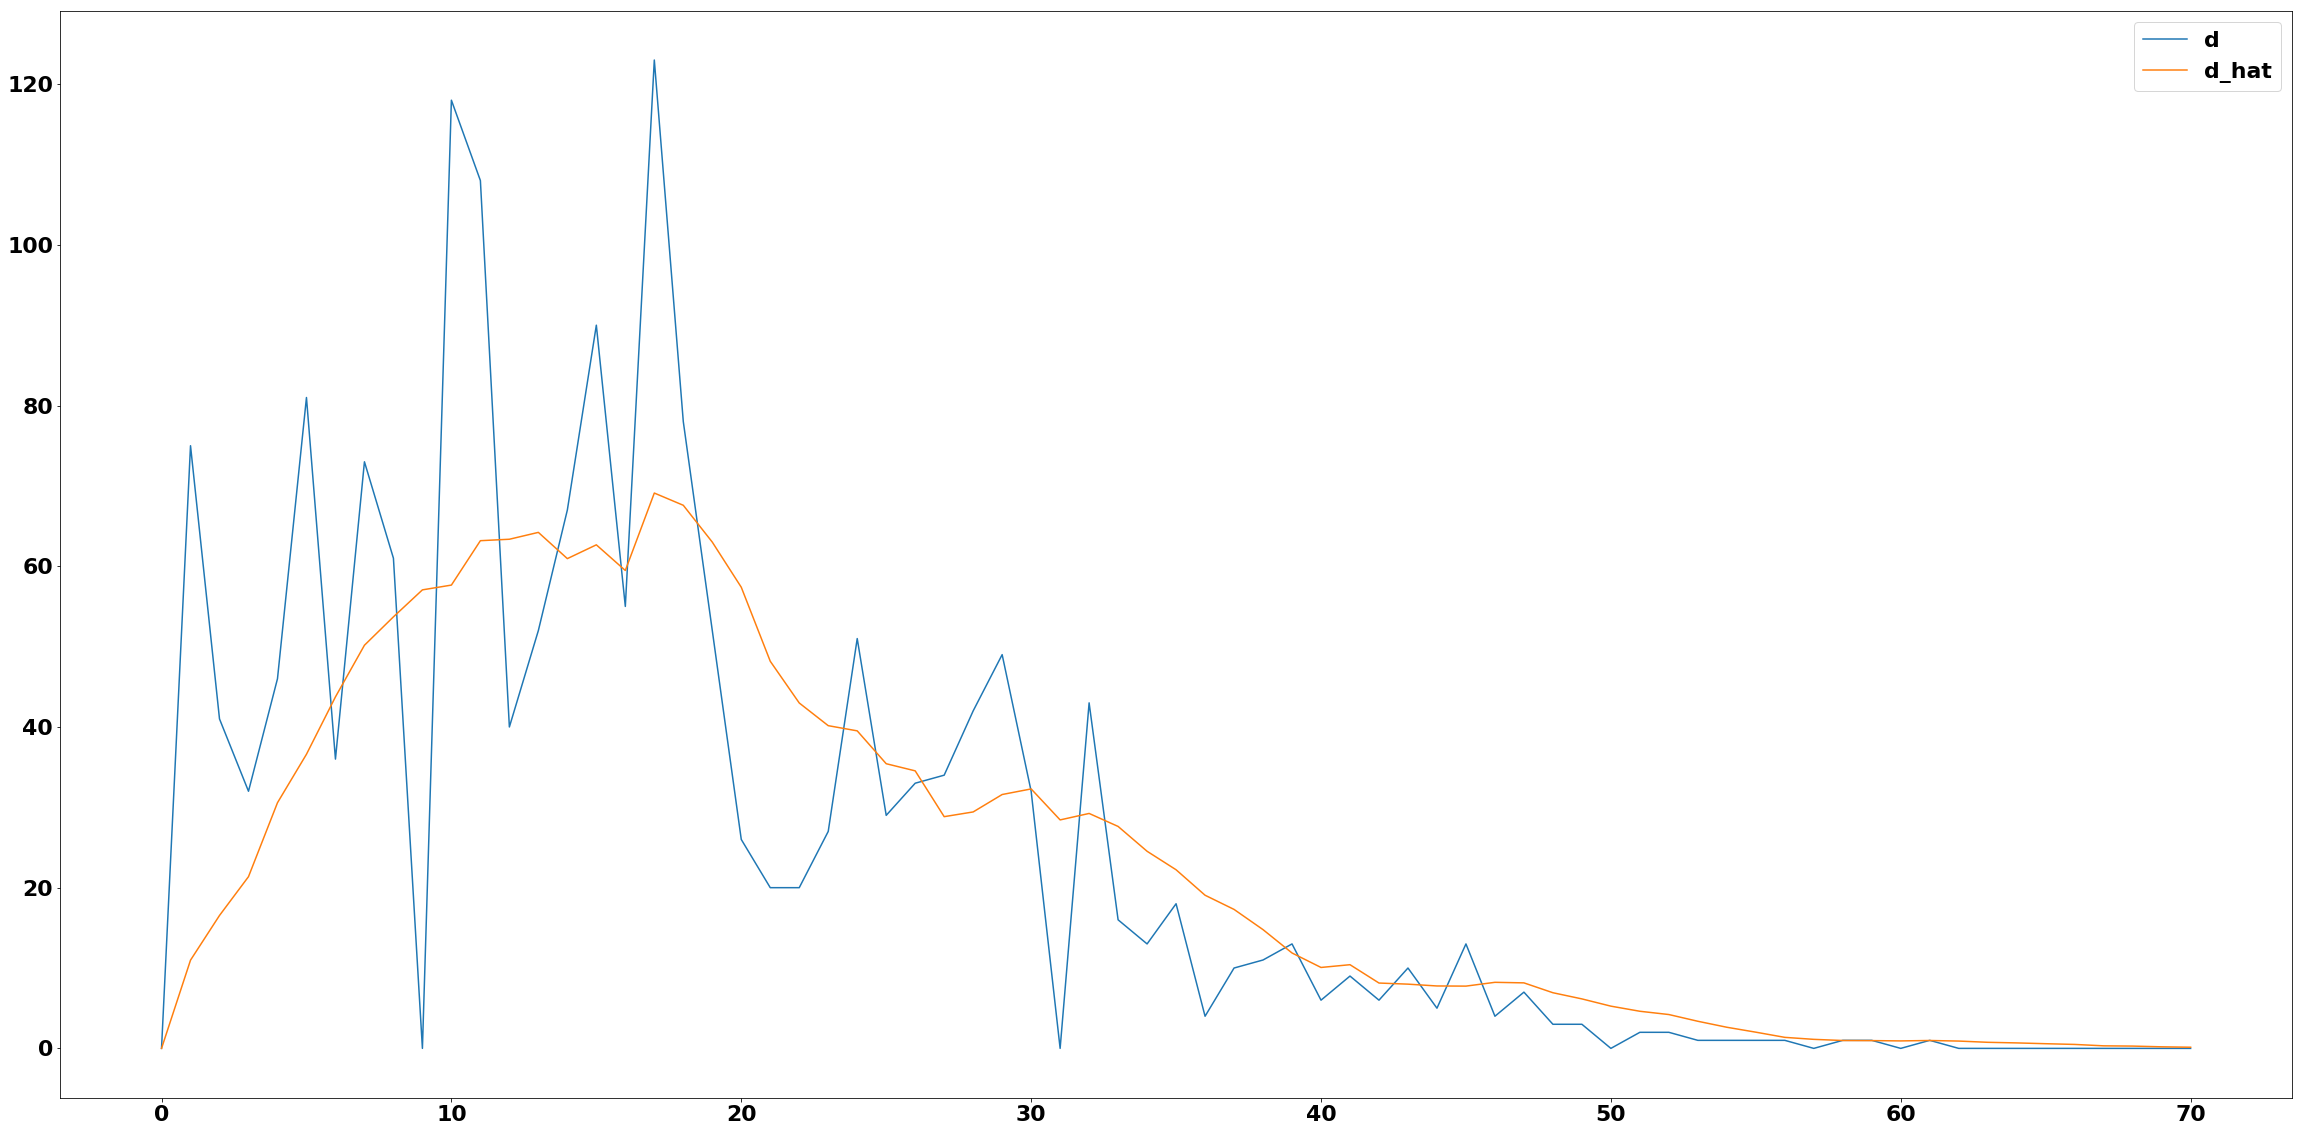

In [76]:
smooth_ebola_guinea_ts = fit_smooth_diff_curve(ebola_guinea_ts)

In [77]:
ebola_sierra_leone_ts = pd.read_csv('data/time_series/ebola_sierra_leone.csv', parse_dates=[0], index_col=0)

Minimum distance=523.8421586551373
Optimal K=26
Optimal alpha=0.021


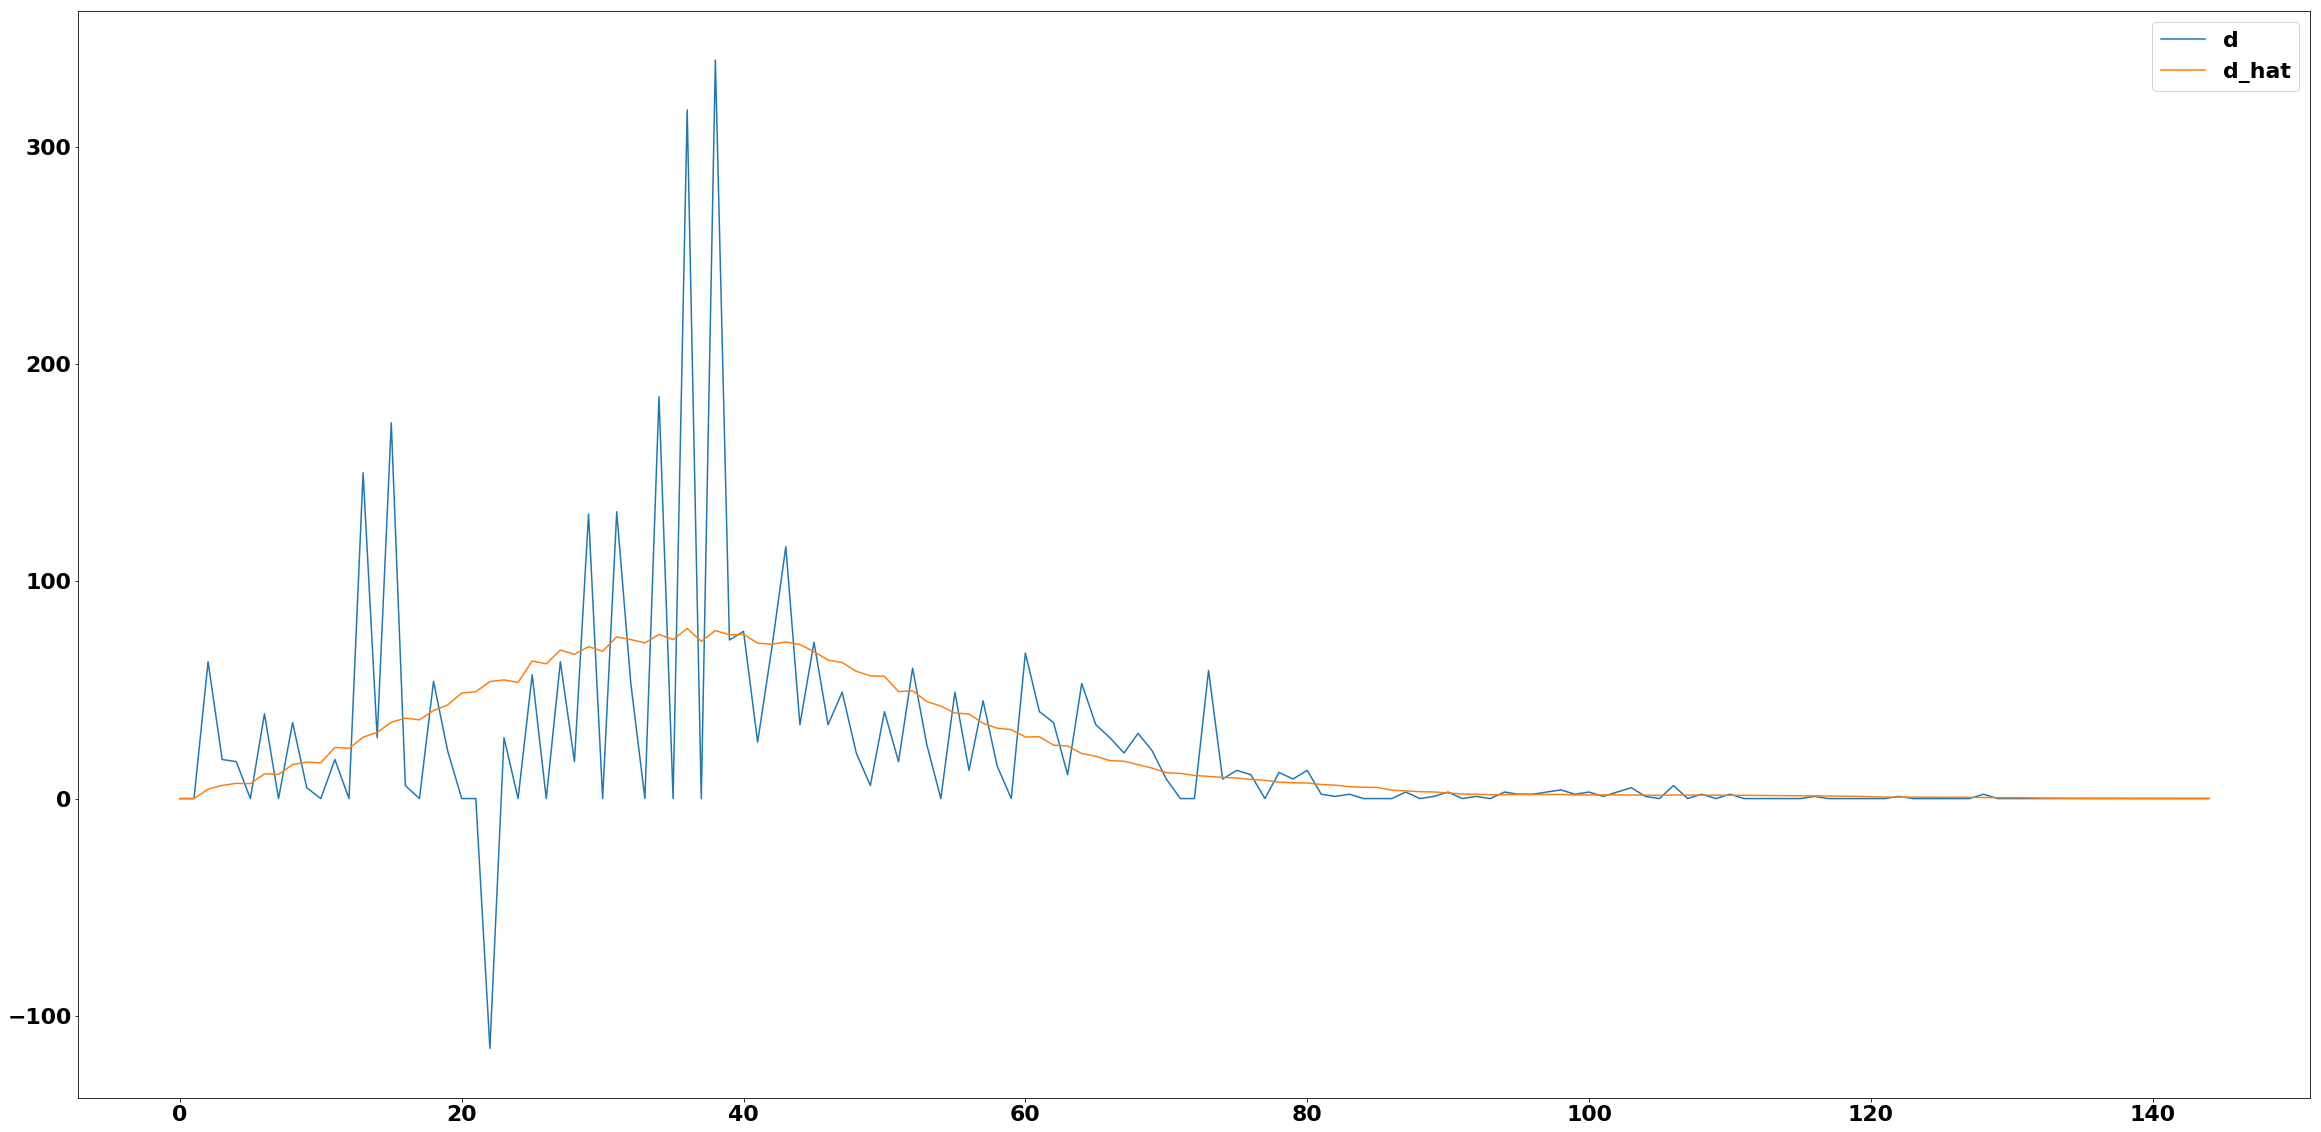

In [81]:
smooth_ebola_sierra_leone_ts = fit_smooth_diff_curve(ebola_sierra_leone_ts, '3D')

## Coronavirus

In [19]:
coronavirus_df = pd.read_csv('../data/time_series/cumulative/Coronavirus.csv', parse_dates=[0], index_col=0).diff().fillna(0)

In [5]:
smooth_coronavirus_df = coronavirus_df.resample('3D').sum()

In [128]:
for k in range(smooth_coronavirus_df.shape[0]):
    estimate_death_curve(
        smooth_coronavirus_df['Infected'].values, 
        smooth_coronavirus_df['Dead'].values,
        K=k
    )
    
# Best performance for K = 3

Minimum distance=769.9850647902205
Optimal K=0
Optimal alpha=1e-06
Minimum distance=331.19704426559537
Optimal K=1
Optimal alpha=0.023123891891891894
Minimum distance=176.21362093182012
Optimal K=2
Optimal alpha=0.013514378378378378
Minimum distance=97.215416886994
Optimal K=3
Optimal alpha=0.009710612612612612
Minimum distance=99.86564377787076
Optimal K=4
Optimal alpha=0.007908828828828828
Minimum distance=128.3209902077664
Optimal K=5
Optimal alpha=0.00670763963963964
Minimum distance=167.6830588567318
Optimal K=6
Optimal alpha=0.006006945945945946
Minimum distance=198.8969207259681
Optimal K=7
Optimal alpha=0.00560654954954955
Minimum distance=217.19434195751435
Optimal K=8
Optimal alpha=0.005406351351351352
Minimum distance=223.80528784515678
Optimal K=9
Optimal alpha=0.005306252252252253


Minimum distance=200.36195237624895
Optimal K=3
Optimal alpha=0.008809720720720721


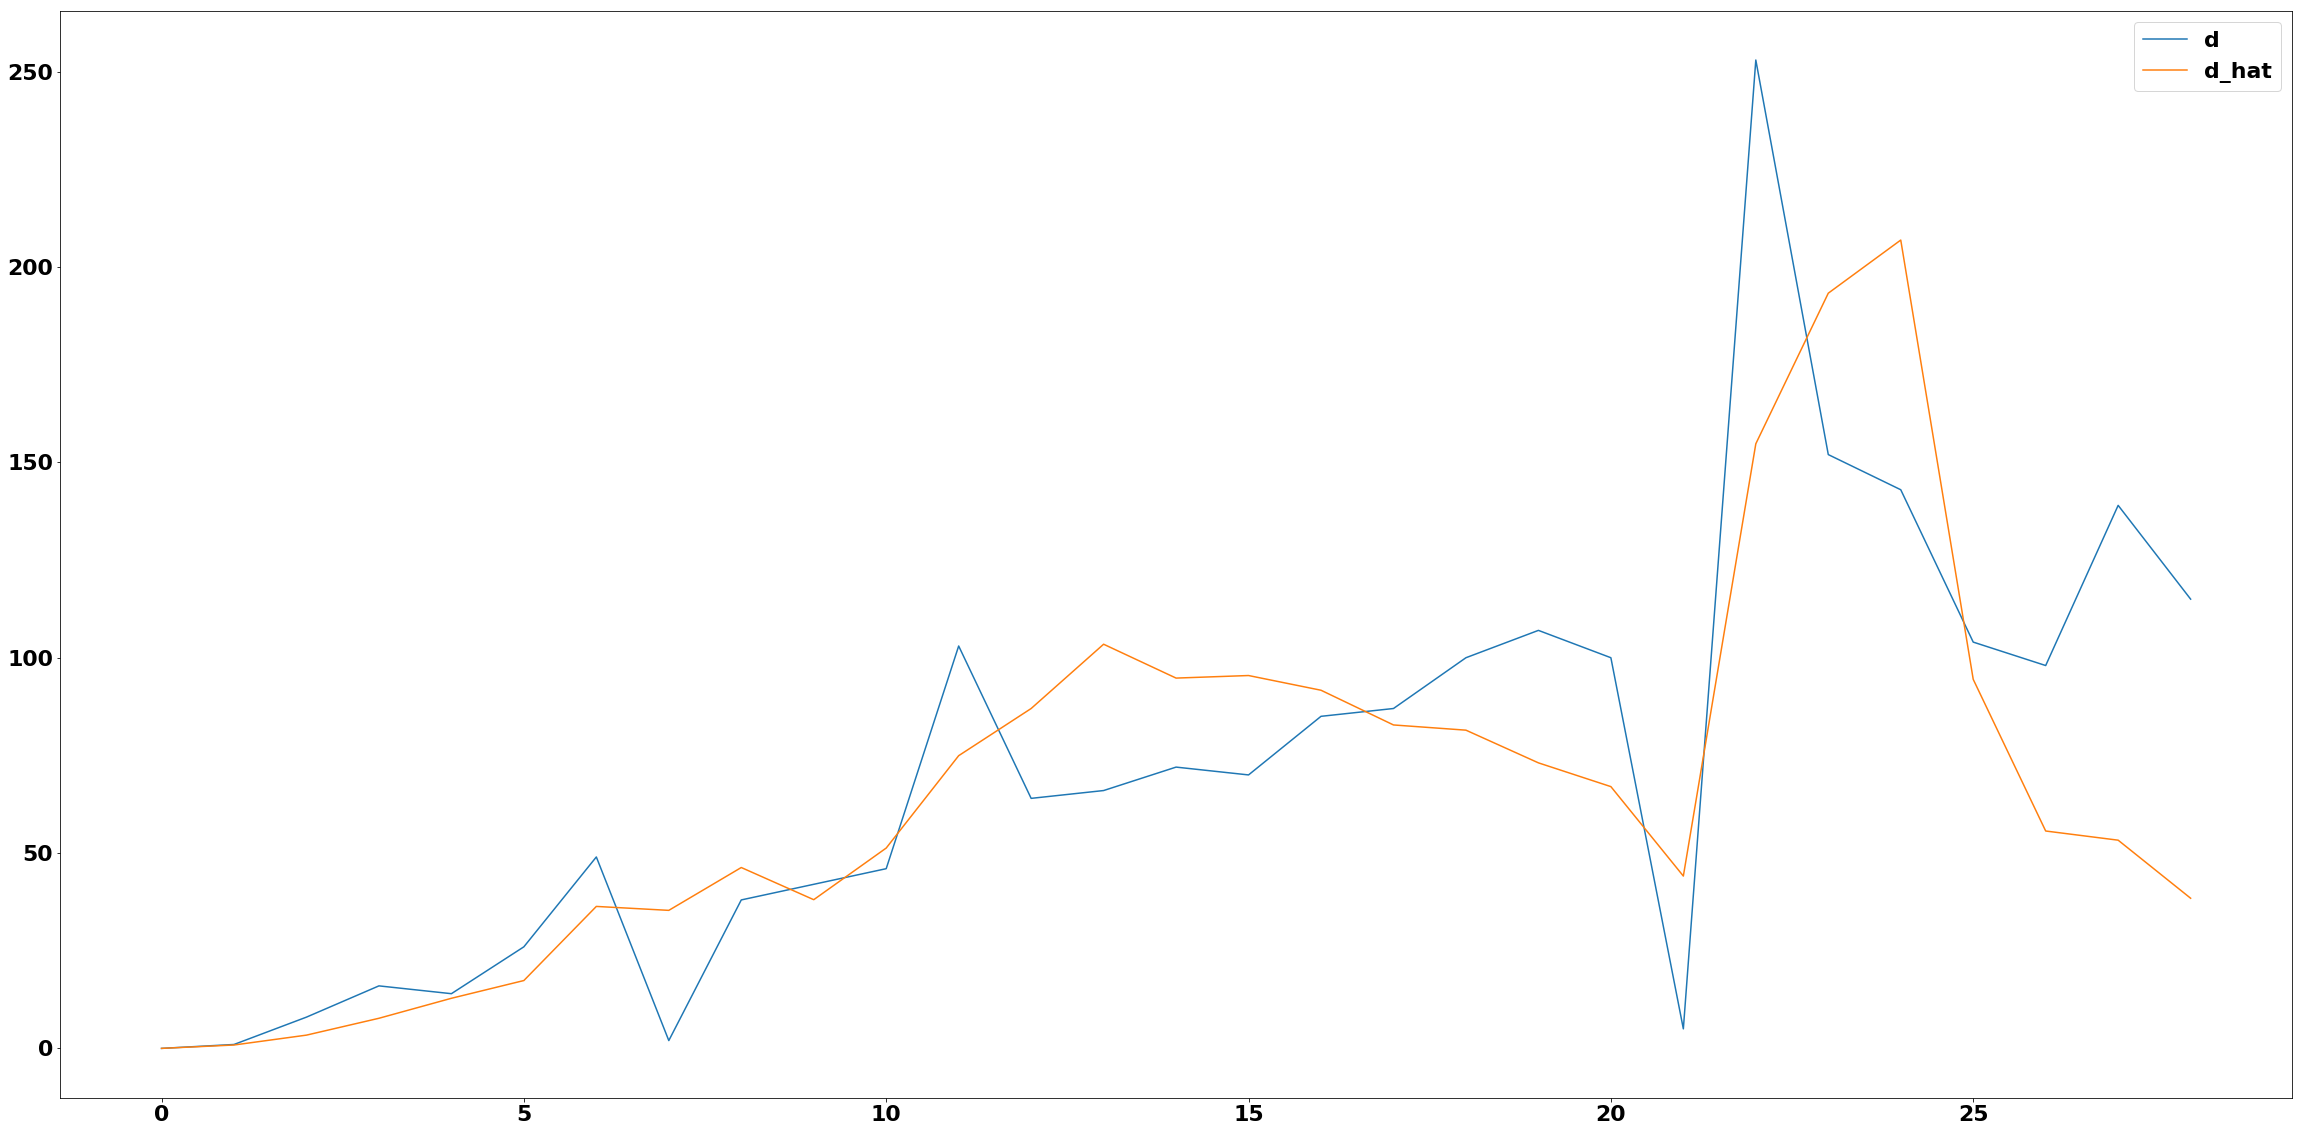

In [129]:
coronavirus_death_curve = estimate_death_curve(
    coronavirus_df['Infected'].values, 
    coronavirus_df['Dead'].values,
    K=3
)

coronavirus_death_curve.plot()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


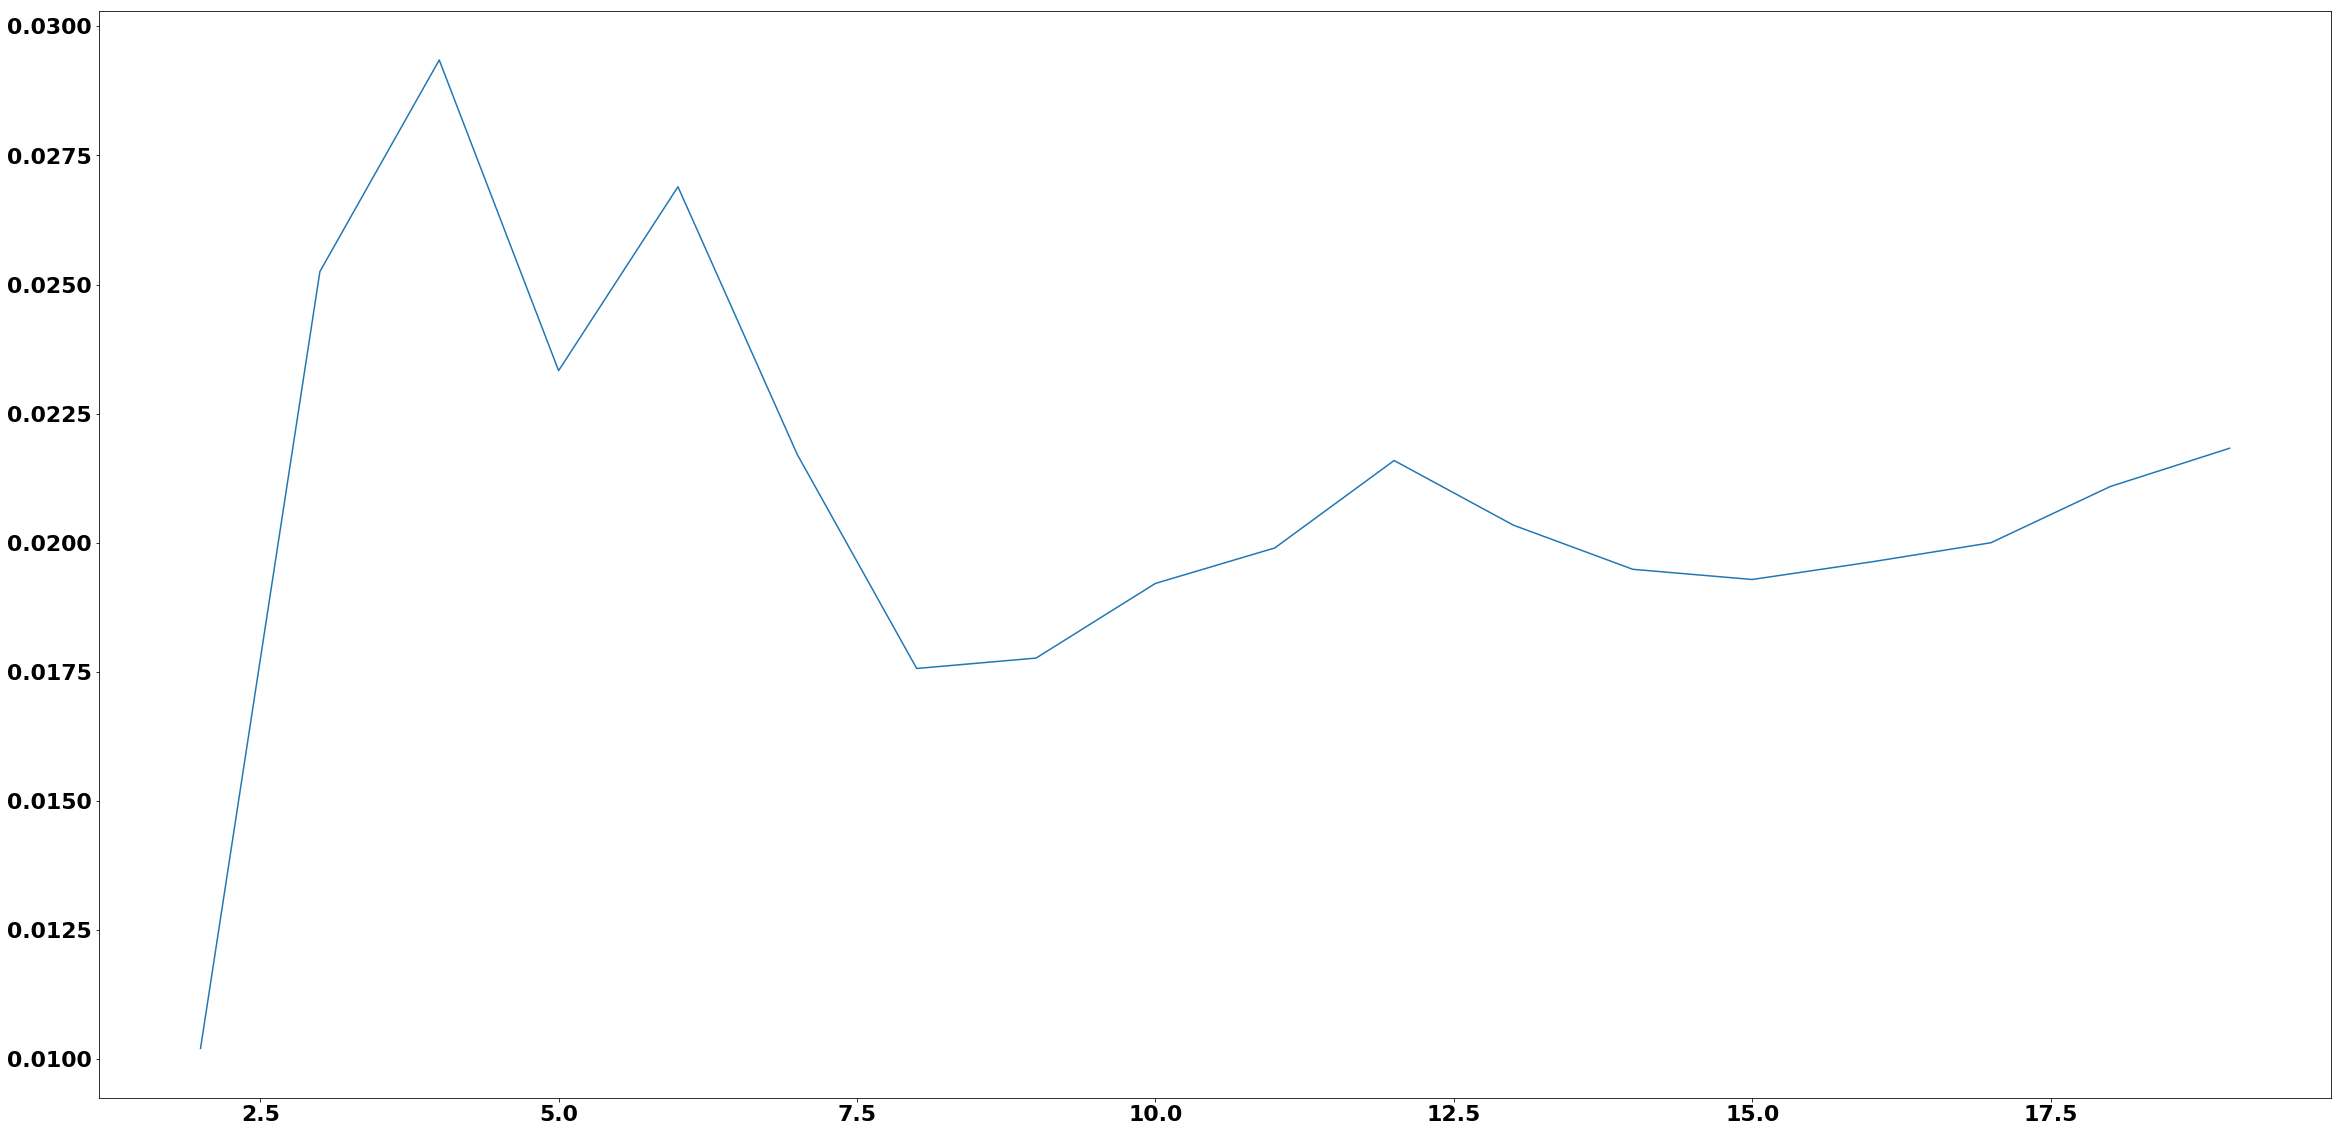

In [131]:
plot_censored_mortality_rate_estimation_evolution(coronavirus_df, 1, 20, K=2)

# Simulate Confidence Interval

## Probability Distribution of Mortality

In [136]:
corona_K = 3
corona_alpha = 0.008809720720720721

In [160]:
def simulate_infected_patients(n_patients, alpha, k0, alpha_k0, K, size=1):
    assert 0 <= k0 and k0 <= K
    
    # recovery probability after K period
    probabilities = [(1 - alpha_k0) * (1 - alpha) ** (K-1)]
    
    for k in range(k0):
        probabilities.append(alpha * (1 - alpha) ** k)
        
    probabilities.append(alpha_k0 * (1 - alpha) ** k0)
    
    for k in range(k0 + 1, K):
        probabilities.append(alpha * (1 - alpha_k0) * (1 - alpha) ** (k-1))
        
    print(probabilities)
        
    return np.random.multinomial(
        n_patients,
        probabilities,
        size=size
    )

def mean_squared_error(estimates, mean):
    return ((estimates - mean) ** 2).mean(1)

In [155]:
def estimate_hazard_rate(X, d, optimal_alpha=corona_alpha, optimal_K=corona_K, n_runs=100):
    T = X.shape[0]
    alpha_space = np.linspace(0.0001, 0.1, 1000)

    result = []
    
    for k0 in range(optimal_K):
        for alpha_k0 in alpha_space:
            alpha_death_curves = np.zeros((n_runs, T))
            
            for t, n_infected in enumerate(X):
                random_paths = simulate_infected_patients(n_infected, optimal_alpha, k0, alpha_k0, optimal_K)
                
                for j in range(n_runs):
                    alpha_death_curves[j, t:t+K] += random_paths[j][1:T - t + 1]
            
    
    for i, alpha in enumerate(alpha_space):
        print(f"({i}/{1000}) Simulating alpha={alpha}...")


        for t, n_infected in enumerate(X):
            random_paths = simulate_infected_patients(n_infected, alpha, K=K, size=n_runs)

            for j in range(n_runs):
                alpha_death_curves[j, t:t+K] += random_paths[j][1:T - t + 1]

        mean_death_curve = alpha_death_curves.mean(0)
    #         all_mean_squared_errors = mean_squared_error(alpha_death_curves, mean_death_curve)
        d_mse = mean_squared_error(d, mean_death_curve)
        print(f"\nConfidence Interval={lower_boundary, higher_boundary}\nTrue Mean Squared Error={true_mean_squared_error}\nIncluded?={true_mean_squared_error >= lower_boundary and true_mean_squared_error <= higher_boundary}\n")


In [152]:
estimate_hazard_rate(
    smooth_coronavirus_df['Infected'].values,
    smooth_coronavirus_df['Dead'].values
)

NameError: name 'estimate_hazard_rate' is not defined